In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def select(query):
    
    conn = sqlite3.connect(r'C:\Users\Pablo\Desktop\pablo\academics\springboard data science\Capstone Project 2\Loan-Risk-Analysis\data\lending-club-loan-data\database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [3]:
#features_train = select('SELECT * FROM final_cat_features_train').drop(['0','1','2','3','4','5','6','7','8','9','10','11'],axis=1)
#targets_train = select('SELECT * FROM final_targets_train')

#features_test = select('SELECT * FROM final_cat_features_test').drop(['0','1','2','3','4','5','6','7','8','9','10','11'],axis=1)
#targets_test = select('SELECT * FROM final_targets_test')

#features_train = pd.concat([features_train,features_test[:40000]]).copy().reset_index(drop=True)
#targets_train = pd.concat([targets_train,targets_test[:40000]]).copy().reset_index(drop=True)

#features_test = features_test[40000:].copy()
#targets_test = targets_test[40000:].copy()

data = pd.read_csv(r'C:\Users\Pablo\Desktop\pablo\academics\springboard data science\machine learning\logistic_regression\data\01_heights_weights_genders.csv')
data.Gender = data.Gender.apply(lambda x: x == 'Male').astype(int)
data = shuffle(data).reset_index(drop=True)
data.Height = (data.Height - data.Height.mean())/data.Height.std()
data.Weight = (data.Weight - data.Weight.mean())/data.Weight.std()

features_train = data[:9500][['Height','Weight']]
targets_train = data[:9500]['Gender']

features_test = data[9500:][['Height','Weight']]
targets_test = data[9500:]['Gender']


# consolidate targets w features for the shuffle
training = features_train.merge(pd.DataFrame(targets_train),left_index=True,right_index=True).copy()

In [4]:
n_inputs = 2
n_hidden_units0 = 2
n_hidden_units1 = 1

X = tf.placeholder(tf.float32,[None,n_inputs])
W0 = tf.Variable(tf.truncated_normal([n_inputs,n_hidden_units0],stddev=1))
b0 = tf.Variable(tf.zeros([n_hidden_units0]))
W1 = tf.Variable(tf.truncated_normal([n_hidden_units0,n_hidden_units1],stddev=1))
b1 = tf.Variable(tf.zeros([n_hidden_units1]))


Y0 = tf.nn.sigmoid(tf.matmul(X,W0)+b0)
Yp = tf.nn.sigmoid(tf.matmul(Y0,W1)+b1)

Y = tf.placeholder(tf.float32,[None])

In [5]:
global_step = tf.Variable(0, trainable=False)
alpha = tf.train.exponential_decay(0.1, global_step, 100, 0.96, staircase=True) # learning rate decay
#alpha = 0.1
mini_batch_size = 100
eps = 10**-15

init = tf.global_variables_initializer()

loss_func = -(1/mini_batch_size)*tf.reduce_sum(Y*tf.log(Yp+eps)+(1-Y+eps)*tf.log(1-Yp+eps))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha)
train_step = optimizer.minimize(loss=loss_func,global_step=global_step)

sess = tf.Session()
sess.run(init)

In [6]:
import time

accus_TRAIN = []
accus = []

i = 0
epochs = 0

test_data = {X:features_test.values,Y:targets_test}
train_data_ALL = {X:features_train.values,Y:targets_train}

tic = time.time()
while(epochs<250):
    if((i+1)*mini_batch_size > len(training)): # evaluate train/test error after each epoch
        training = shuffle(training).reset_index(drop=True)
        i = 0
        epochs+=1
        
        y_p_TRAIN = []
        for k in sess.run(Yp,feed_dict=train_data_ALL):
            y_p_TRAIN.append(k[0])
        
        y_p = []
        for k in sess.run(Yp,feed_dict=test_data):
            y_p.append(k[0])
        
        predictions_TRAIN = pd.Series(y_p_TRAIN)
        predictions_TRAIN = predictions_TRAIN.apply(lambda x: x>0.5).astype(int)
        
        predictions = pd.Series(y_p)
        predictions = predictions.apply(lambda x: x>0.5).astype(int)        
        
        accus_TRAIN.append(accuracy_score(targets_train.values,predictions_TRAIN.values))
        accus.append(accuracy_score(targets_test.values,predictions.values))

        continue
        
    batch_X = training.drop('Gender',axis=1).iloc[i*mini_batch_size:(i+1)*mini_batch_size].values
    batch_Y = training.Gender.iloc[i*mini_batch_size:(i+1)*mini_batch_size].values
    train_data = {X:batch_X,Y:batch_Y}
    
    sess.run(train_step,feed_dict=train_data)
    i+=1
toc = time.time()

print(toc-tic)

94.90879940986633


In [7]:
sess.close()

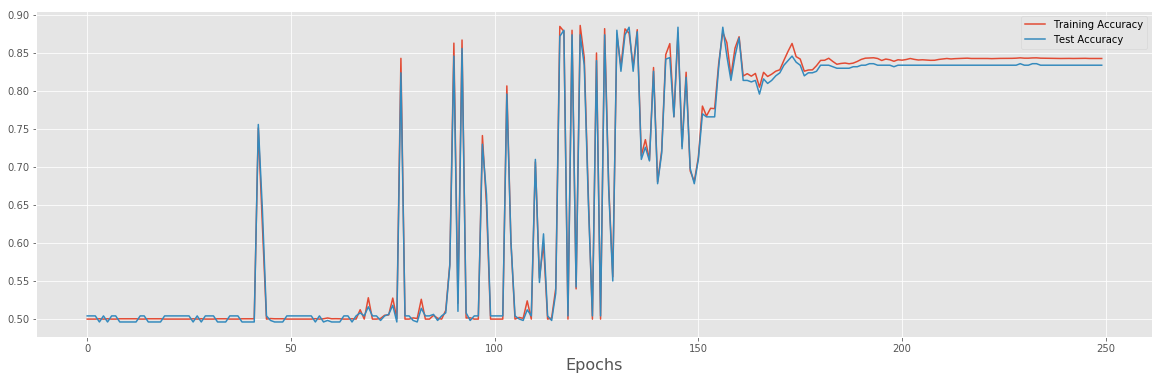

In [11]:
# need to use weight decay? not converging

fig, ax = plt.subplots(1,1,figsize=(20,6))

ax.plot(list(range(250)),accus_TRAIN)
ax.plot(list(range(250)),accus)
ax.set_xlabel('Epochs',fontsize=16)

ax.legend(['Training Accuracy','Test Accuracy'])

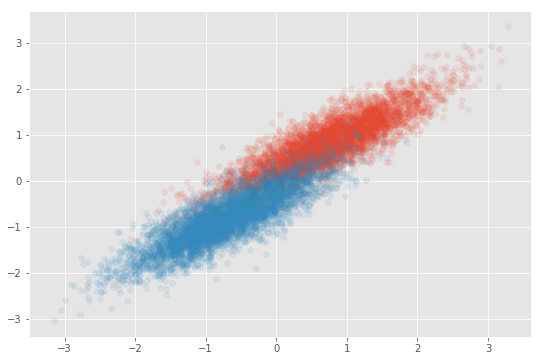

In [9]:
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.scatter(data[data.Gender==1].Height,data[data.Gender==1].Weight,alpha=0.1)
ax.scatter(data[data.Gender==0].Height,data[data.Gender==0].Weight,alpha=0.1)